<a id='top'></a>

<span  style="color:green; font-size: 250%;">M3-W5 Project: Make your Data shine! </span>

# Members: Barry Luke, Schreckenberger Moritz, Harrabi Raouf
# Team: Treasure-Hunters

--------
##  Assignment Steps:

Step 1: In this module project your task is to pick a dataset from the link below <br>
Step 2: Load it to Python using an appropriate library (pandas, sqllite3, etc.) <br>
Step 3: Understand the issues (take a look at the issues section for each dataset on the given URL)  <br>
Step 4: Clean the data (take care of outliers, missing values, data types, etc.) and provide explanations for all steps you took while cleaning the data  <br>
Step 5: Explore and visualize your data <br>


Overarching: Submit your work as a Jupyter Notebook with all the code and narrative. 
__________

### [*Column Cleaning Notes*](#cleaning)
<a id='top'></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
from tqdm.notebook import tqdm #progress bar for time consuming functions
import nltk # Natural Language Toolkit
from IPython.display import Image
from IPython.display import display


pd.set_option('float_format', '{:g}'.format)

# import fuzzywuzzy

## Step 1: Pick a dataset
We chose the Database of The Metropolitan Museum of Art Open Access and generated the file "MetObjects.csv"
____________

## Step 2: Load the database to Python using an appropriate library (pandas, sqllite3, etc.)
Since we are handling a csv-file we will import via csv-package
____________

## Step 3: Understand the issues (take a look at the issues section for each dataset on the given URL)

**Issues: Missing values, inconsistent information, missing documentation, possible duplication, mixed text and numeric data.**
____________

We will first fix the memory size of the file, since it is a quite large DataSet with about 470k rows and about 50 columns.<br>
In total we have to handle 25,1 mio entries. The aspiration is set high ;-)

In [3]:
## Collection of all functions
# Defining functions for reducing the memory size and unify the column names
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization is {:.2f} MB'.format(start_mem))
    print('-' * 45)

    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('-' * 45)

    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(csv,index):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(csv,low_memory=False,index_col=index)
    df = reduce_mem_usage(df)
    return df

def rename_cols(df):
    """rename columns of a DF"""

    df.columns = df.columns.str.replace(' ', '_') 
    df.columns = df.columns.str.lower()    
    return df.columns

def convert_col_int8(df):
    """convert cols to int8"""

    temp_df = pd.DataFrame()
    for column in df.columns:
        temp_df[column] = df[column].astype("int8")

    return temp_df


# we decided to use only the year as a valuable information
def get_year(col):
    """get the year from the datetime col"""

    if 'artist' in col.name and 'date' in col.name or 'year' in col.name:
        new_col = pd.to_datetime(col.str.slice(0, 4), format='%Y', errors='coerce').dt.year
            #print('\n', df[col])
    if 'object' in col.name and 'date' in col.name:
        new_col = pd.to_datetime(col, format='%Y', errors='coerce').dt.year
    df.drop(col.name,axis=1,inplace=True)

    return new_col

# Get the top 5 entries from tags for visual EDA
def return_top_5_entries(col):
    """get the top 5 entries of a list within a column"""
    tag_dict = {}
    for tags in col:
        for i in range(len(tags)) :
            if tags[i] in tag_dict:
                tag_dict[tags[i]] = tag_dict[tags[i]] + 1
            else:
                tag_dict[tags[i]] = 1
    return sorted(tag_dict.items(), key =  lambda kv:(kv[1], kv[0]),reverse=True)[:5]   

# Convert columns to category type for correlation matrix
def convert_cat_2_num(df):
    """convert the columns of a DataFrame into category type"""
    temp_df = pd.DataFrame()

    for column in df.columns:
        temp_df[column] = df[column].astype("category").cat.codes
    return temp_df

In [4]:
# Calling the function to reduce memory size
df = import_data("MetObjects.csv",4)

Memory usage before optimization is 185.86 MB
---------------------------------------------
Memory usage after optimization is: 168.95 MB
---------------------------------------------
Decreased by 9.1%


In [5]:
# Looking at a sample to get a first understanding of the Dataset and the issues with the dataset
df.sample(10)
# We see many issues amongst: NaN-Values, non-Boolean-Values, inconsistent data

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
Object ID,,,,,,,,,,,,,,,,,,,,,
693894,28.99.77,0,0,1,NaN,Medieval Art,1928,Fragment,Fragment,European or Middle Eastern,...,NaN,Glass-Vessels,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
409167,63.350.201.21.32,0,0,1,NaN,Drawings and Prints,1963,Print,"Moose, from the Quadrupeds series (N21) for Al...",NaN,...,NaN,Prints|Ephemera,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",Animals,http://vocab.getty.edu/page/aat/300249525,https://www.wikidata.org/wiki/Q729
209354,37.20.117,0,0,1,NaN,European Sculpture and Decorative Arts,1937,Fruit dish,Fruit dish (part of a service),"French, Sèvres",...,NaN,Ceramics-Porcelain,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",Flowers,http://vocab.getty.edu/page/aat/300132399,https://www.wikidata.org/wiki/Q506
354268,24.66.1406(74r),0,0,0,NaN,Drawings and Prints,1924,Drawing Ornament & Architecture,"University of North Carolina, Chapel Hill, Stu...",NaN,...,NaN,Drawings|Ornament & Architecture,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
159406,2009.300.831,0,0,0,NaN,Costume Institute,2009,Evening dress,Evening dress,American,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
784697,63.350.244.85-2.149,0,0,0,NaN,Drawings and Prints,1963,Print; ephemera,"Charles Ray, from the ""Movie Stars"" series (T8...",NaN,...,NaN,Prints|Ephemera,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
652972,2004.101.16,0,0,1,NaN,Arms and Armor,2004,Drawings,Design for the Decoration of Firearms,"French, Versailles",...,NaN,Works on Paper-Drawings,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",Ornament,http://vocab.getty.edu/page/aat/300164595,https://www.wikidata.org/wiki/Q335261
42103,02.18.701,0,0,1,222,Asian Art,1902,Bowl,清嘉慶 白玉碗|Bowl,China,...,NaN,Jade,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",Bowls,http://vocab.getty.edu/page/aat/300203596,https://www.wikidata.org/wiki/Q153988
634705,63.350.243.51.173,0,0,0,NaN,Drawings and Prints,1963,Print,"University of Denver, from the College series ...",NaN,...,NaN,Prints|Ephemera,NaN,http://www.metmuseum.org/art/collection/search...,NaN,nan,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


In [6]:
# Looking at the info to better understand the issues with the dataset and the severity of missing values! 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474169 entries, 1 to 849460
Data columns (total 53 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Object Number            474169 non-null  category
 1   Is Highlight             474169 non-null  float16 
 2   Is Timeline Work         474169 non-null  float16 
 3   Is Public Domain         474169 non-null  float16 
 4   Gallery Number           54984 non-null   category
 5   Department               474169 non-null  category
 6   AccessionYear            469612 non-null  category
 7   Object Name              472664 non-null  category
 8   Title                    444568 non-null  category
 9   Culture                  206594 non-null  category
 10  Period                   90413 non-null   category
 11  Dynasty                  23144 non-null   category
 12  Reign                    11179 non-null   category
 13  Portfolio                23460 non-null   ca

In [7]:
# So we do a detailed check for NaN-Values
df.isnull().sum().sort_values(ascending = False)

Metadata Date              474169
River                      472071
State                      471642
Locus                      466768
County                     465824
Reign                      462990
Artist Suffix              462235
Locale                     458564
Excavation                 458159
Subregion                  452110
Object Wikidata URL        452052
Dynasty                    451025
Portfolio                  450709
Rights and Reproduction    450575
Region                     442827
City                       442175
Gallery Number             419185
Geography Type             414807
Country                    398884
Artist Prefix              384745
Period                     383756
Artist Gender              372831
Artist Nationality         291787
Culture                    267575
Artist Wikidata URL        266474
Artist ULAN URL            261772
Tags Wikidata URL          259642
Tags AAT URL               258335
Tags                       257864
Artist Display

In [8]:
# Checking the shape of the dataset
df.shape

(474169, 53)

In [9]:
# Luckily we do not have duplicated values(at least)
df.duplicated().sum()

0

In [10]:
# Checking some statistical values
df.describe()
# In this case not very insightful, since only a few columns do contain numbers (and not strings) and those often are IDs

,Is Highlight,Is Timeline Work,Is Public Domain,Object Begin Date,Object End Date,Metadata Date
count,474169,474169,474169,474169,474169,0
mean,0.00504303,0.0168304,nan,1293.67,1394.48,nan
std,0.0708618,0.128784,0,1719.39,1135.34,nan
min,0,0,0,-400000,-240000,nan
25%,0,0,0,1525,1580,nan
50%,0,0,1,1800,1835,nan
75%,0,0,1,1890,1904,nan
max,1,1,1,5000,15335,nan


In [11]:
# Pulling one example of an art object (one row) to better understand what kind of data is stored per object
df.loc[849455,:]

Object Number                                           DP.Lichtenstein.2021
Is Highlight                                                               0
Is Timeline Work                                                           0
Is Public Domain                                                           0
Gallery Number                                                           NaN
Department                                               Drawings and Prints
AccessionYear                                                            NaN
Object Name                                                            Print
Title                                  Group of 2 prints by Roy Lichtenstein
Culture                                                                  NaN
Period                                                                   NaN
Dynasty                                                                  NaN
Reign                                                                    NaN

#### Visualization of missing values in the heatmap before the cleaning process
<!-- [Heatmap Before Cleaning](#heatmap0) <br> -->
<a id='heatmap0'></a>
[Heatmap After Cleaning](#heatmapZ)

<AxesSubplot:ylabel='Object ID'>

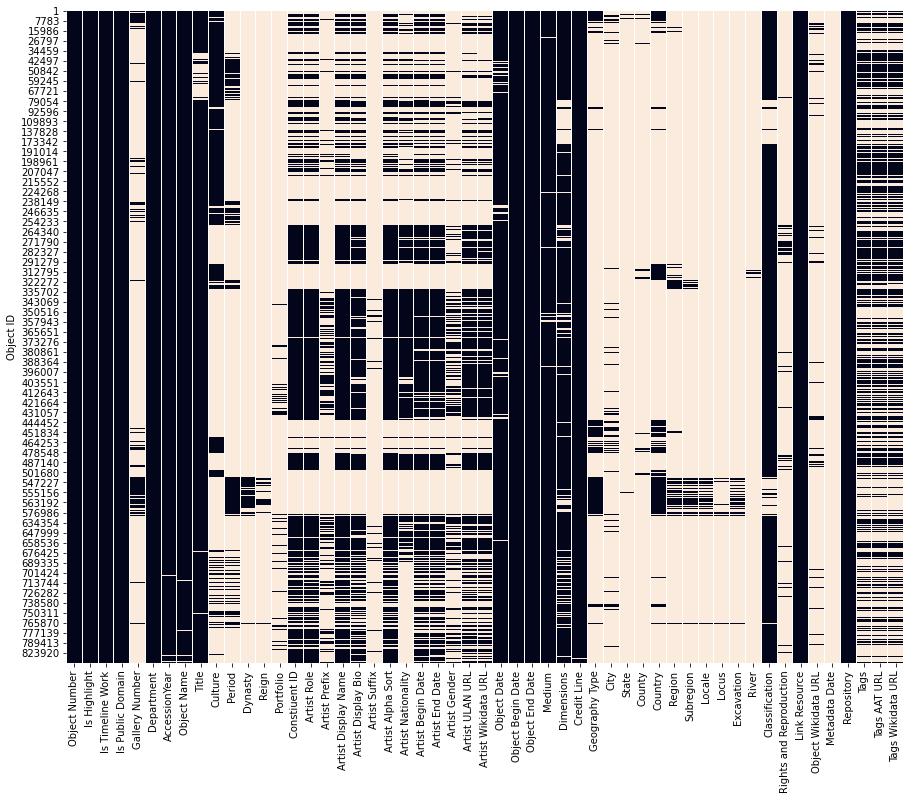

In [12]:
# Let's quickly take a look at how the values are distributed along the rows and columns
plt.figure(figsize=(15,12))
sns.heatmap(df.isnull(), cbar=False)

## Step 4: Clean the data (take care of outliers, missing values, data types, etc.) and provide explanations for all steps you took while cleaning the data

Now with the steps we took above, we have gained an overview of the issues we are facing.<br>
We will now start applying various operations to clean the data and try to solve the above mentioned issues.
____________

In [13]:
# Calling the function to rename the columns (unified format of underscore and lowercase)
df.columns = rename_cols(df)

#### 4.1 Dropping Rows of the DataFrame
We will narrow the data down to only include rows that have entries in the "artist_display_bio"-column.  <br>
In order to comprehend and understand the reasoning behind the above of excluding approximately 50% of the rows, we have to look at several different arguments:
1. **Pattern and initial information** <br>
   You can identify a strong link between missing data in columns like "artist_display_bio", "constiuent_id", "artist_ulan_url" and a few more (middle part of the graphic). <br>
   From our understanding of the history of the data (how the data was gathered), it seems like the URL was scraped and used as a data input for many of the above mentioned columns. <br>
   This leads to the conclusion that if one entry is missing the other entries in the linked column are most likely to not contain any other information, too. <br>
   See [Heatmap](#heatmap1)

   
2. **No other source of information to fill values** <br>
   The alternative of keeping the empty rows and trying to fill them with additional information, leads to the same issue mentioned above. The only additional source of info are the URLs. <br>
   Scanning through those URLs (where there is no "artist_display_bio" information) shows, that these URLs are not garuanteed to be helpfull to fill the remaining entries, but in contrary also show missing information here. <br>
   See examples of [URLs](#URLs) for missing "artist_display_bio" information <br>
   
3. **Business Perspective** <br>
   Also from a business perspective this makes sense: About 5% of a museums artworks make up about 80% of their networth (reflected e.g. by insurance policy sums). <br>
   Therefore we are mainly excluding unkown and low priority artworks, probably not even displayed.<br>
   Example see [here](https://repository.uchastings.edu/cgi/viewcontent.cgi?article=2462&context=hastings_law_journal), "*...Of these museums 99 percent probably account for less than 10 percent of the insurable values.*"* <br>

<a id='heatmap1'></a>
**1. Pattern and initial information**

<AxesSubplot:title={'center':'Comparable pattern of missing data in related columns'}, ylabel='Object ID'>

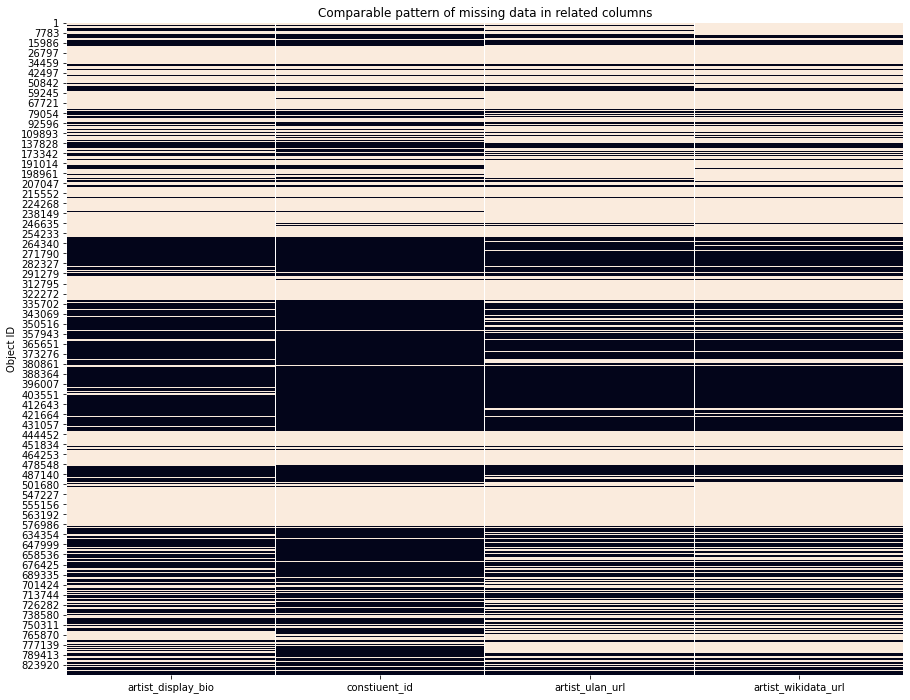

In [14]:
plt.figure(figsize=(15,12))
plt.title("Comparable pattern of missing data in related columns")
sns.heatmap(df[["artist_display_bio","constiuent_id","artist_ulan_url","artist_wikidata_url"]].isnull(), cbar=False)

<a id='URLs'></a>
**2. No other source of information to fill values**

In [15]:
# Creating a dataframe to easily access the urls for inspection
not_null_urls = df[ df.loc[ :,["artist_wikidata_url", "artist_ulan_url"] ].notnull().sum(axis=1) == 2]
not_null_urls[["artist_wikidata_url", "artist_ulan_url"]].isnull().mean() #showing there is 0 null values

artist_wikidata_url   0
artist_ulan_url       0
dtype: float64

In [16]:
#separating and inspecting urls where artist_display_bio is null
to_inspect = not_null_urls[["artist_display_bio","artist_wikidata_url", "artist_ulan_url"]]
display_null = to_inspect[ to_inspect.loc[ :,["artist_display_bio"] ].isnull().sum(axis=1) == 1]
display_null.iloc[2000:2015, 0:3] #sample section

,artist_display_bio,artist_wikidata_url,artist_ulan_url
Object ID,,,
339926,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339927,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339928,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339929,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339930,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339933,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339934,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339935,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994
339941,NaN,https://www.wikidata.org/wiki/Q4233718,http://vocab.getty.edu/page/ulan/500397994


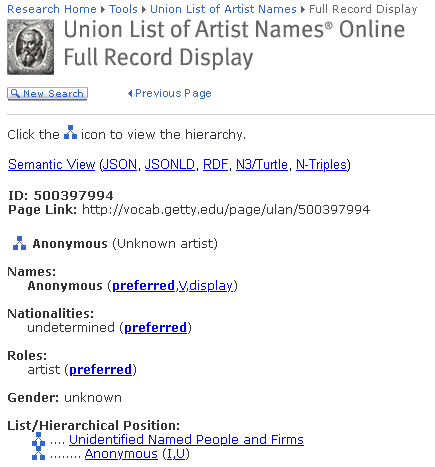

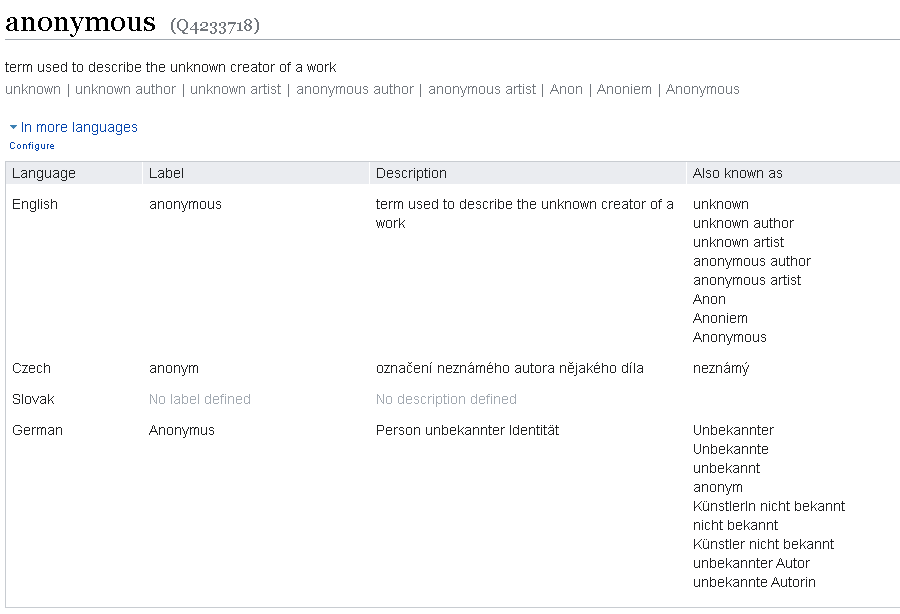

None


In [17]:
#inspecting these urls reveals that there is no useful information in many of the url values
#images below are taken from the urls
x = Image(filename="faulty_url_1.PNG") 
y = Image(filename="faulty_url_2.PNG") 
print(display(x, y))

In [18]:
# As a conclusion we will drop the rows:
df = df[pd.notnull(df['artist_display_bio'])]
# Continue issue-handling with the reduced dataset
len(df)

233597

In [19]:
# Changing the columns with integer-values
lst_int = ["is_highlight","is_timeline_work","is_public_domain"]
df[lst_int] = convert_col_int8(df[lst_int])

#### 4.2 Handling Nationality

In [20]:
# #################################  + commented to not waste time every new run +   ######################

# # because the loop take long time to finish, we decided to create a new Dataset after finishing the executuion: 
# # so we dont have to wait every time we need to re-reun

# # create a new col artist_nationality_new that will grap some info from the col artist_display_bio
# nat_file = "CH_Nationality_List_20171130_v1.csv"
# df_nationalities = pd.read_csv(nat_file)
# df_nationalities.head()
# nats = df_nationalities.values.tolist()
# len(nats)
# df['artist_nationality_new'] = ""
# for index,row in tqdm(df[df.notnull()].iterrows()):
#     for ind,nat in df_nationalities.iterrows():
#         if str(df_nationalities.iloc[ind,0]) in str(row[18]):
#             df.loc[index,'artist_nationality_new'] = df_nationalities.iloc[ind,0]

#### 4.3 Enhancing the missing values in "medium

In [21]:
# #################################  + commented to not waste time every new run +   ######################
# # Listing major key words
# medium_keywords = ["album","sheet","manuscript","drawing","map","collection","catalogue",
#                    "paper","portrait","poem","illustration","illustrated","livre","book",
#                    "chanson","journal","oeuvres","furniture","letter","design","note","document","photo"]
# # Check instances where medium is NaN and title contains keywords like catalogue, book, portrait, illustration
# medium_nan_before = df[df["medium"].isna()]["title"].count()
# # Changing the column type for the following loops
# df['medium'] = df['medium'].astype('object')
# df["title"] = df['title'].astype('object')
# # Iteration through every instance where medium is NaN and checking if the defined keywords are in the title column
# count = 0
# for row_index in df[df["medium"].isna() == True].index:
#     title = df.loc[row_index,["title"]]
#     split_title = str(title).lower().split()
#     for entry in split_title:
#         if entry in medium_keywords:
#             count += 1
#             # print(entry)
#             df.loc[row_index,["medium"]] = entry
# print("With the keyword-list, we found",count,"matches for the medium column.")
# # Changing the column type for the following loops
# df['medium'] = df['medium'].astype('category')
# df["title"] = df['title'].astype('category')
# medium_nan_after = df[df["medium"].isna()]["title"].count()
# print("With the above method we eliminated",medium_nan_before-medium_nan_after,"NaN-entries and filled them with reasonable values.")

#### 4.4 Handling Artist gender

In [22]:
df.artist_gender.value_counts()

|                                                                                                               53614
||                                                                                                              20595
Female                                                                                                           8192
|||                                                                                                              6105
Female|                                                                                                          2564
                                                                                                                ...  
|||||Female||||||||||||||                                                                                           1
|||||Female||||||||||||Female|||Female|||||||||                                                                     1
|||||Female||||||||||||                                 

In [23]:
##################################  + commented to not waste time every new run (4 hours!) +   ######################

# mlname_df = pd.read_csv("../input/males-females/males.csv")
# fname_df = pd.read_csv("../input/males-females/females.csv")
# # preparing a list of examples and corresponding class labels
# labeled_names = ([(name, 'male') for name in mlname_df["name"]]+ [(name, 'female') for name in fname_df["name"]]) 
# # we use the feature extractor to process the names data 
# featuresets = [(gender_features(name), gender)  for (name, gender)in labeled_names] 
# # divide into a training set and a test set 
# train_set, test_set = featuresets[1500:], featuresets[:1500] 
# # train a new "naive Bayes" classifier 
# classifier = nltk.NaiveBayesClassifier.train(train_set) 
# # some cleaning before looping
# df["artist_gender"] = df["artist_gender"].str.lower()
# df["artist_gender"] = df["artist_gender"].str.replace("|","")

# for index, row in tqdm(df.iterrows()):
#         if str(row[24]).find("female") != -1:
#             df.loc[index,"artist_gender"] = "female"
#         elif str(row[24])== '':
#             df.loc[index,"artist_gender"] = classifier.classify(gender_features((str(df.loc[350,"artist_display_name"]).split(maxsplit=1)[0])))
# # export to csv
# df.to_csv("new_dataset.csv")

# import the new Dataset and continue the work
df = import_data("new_dataset.csv",0)
# dont forget to delte this line
df = df[pd.notnull(df['artist_display_bio'])]

Memory usage before optimization is 98.02 MB
---------------------------------------------
Memory usage after optimization is: 90.46 MB
---------------------------------------------
Decreased by 7.7%


In [24]:
df.artist_gender.value_counts()

male      84840
female    13493
Name: artist_gender, dtype: int64

#### 4.5 Handling Dates

In [25]:
# creating new cols with new names and only the year

dates_names = ["accession_year","object_year","object_begin_year","object_end_year","artist_begin_year","artist_end_year"]
old_names = ["accessionyear","object_date","object_begin_date","object_end_date","artist_begin_date","artist_end_date"]
for i in range(len(dates_names)):
    df[dates_names[i]] =  get_year(df[old_names[i]])

df[dates_names].head()

,accession_year,object_year,object_begin_year,object_end_year,artist_begin_year,artist_end_year
Object ID,,,,,,
1,1979,1853,1853,1853,1794,1869
2,1980,1901,1901,1901,1785,1844
10,1979,1912,1912,1912,1867,1917
11,1979,1907,1907,1907,1785,1844
12,1979,1876,1876,1876,1794,1869


In [26]:
## checking outliers

print("max values of object_end_year before handling: ", int(df.object_end_year.max()))
print("max values of artist_end_year before handling: ",int(df.artist_end_year.max()))
print("total outliers in object_end_year :", sum(df.object_end_year >= 2021))
print("total outliers in artist_end_year :", sum(df.artist_end_year >= 2021))

## Inspecting entries with years above 2021
## There is no evidence that the years have been set to future dates (e.g. 2050) on purpose (looking at the artworks) but rather by accident
## Therefore we change their values to 2021 (also to minimize the effect on statistical values)

df.loc[df.artist_end_year >= 2021,"artist_end_year"] =  2021
df.loc[df.object_end_year >= 2021,"object_end_year"] =  2021

print("max values of object_end_year after handling: ", int(df.object_end_year.max()))
print("max values of artist_end_year after handling: ", int(df.artist_end_year.max()))

max values of object_end_year before handling:  2099
max values of artist_end_year before handling:  2113
total outliers in object_end_year : 36
total outliers in artist_end_year : 3115
max values of object_end_year after handling:  2021
max values of artist_end_year after handling:  2021


In [27]:
# We can drop this column, since it has all the same (but a bit less) information than object_begin_year. 
# We are not losing any information but only sliming the dataset
df = df.drop('object_year', axis=1)

#### 4.6 City information from "artist_suffix" - column

In [28]:
# Artist Suffix Column
# Checking the values here one can see mainly random information about cities or NaN values. We take this information and use it to complete the city column
# The city information in the "Artist Suffix"-Column always starts after a ","-sign and is capitalized. We will search for this and add it to city-column

df['artist_suffix'].value_counts()

, Paris                                                               2195
, Venice                                                               848
(?)                                                                    317
, Rome                                                                 253
, Cologne                                                              187
                                                                      ... 
, prologue                                                               1
, probably|, probably                                                    1
, probably; or|, possibly                                                1
, prob.|and his pupil, Willem Key|(Judas, Christ, vessel on floor)       1
& Beccles|, London                                                       1
Name: artist_suffix, Length: 1316, dtype: int64

In [29]:
# We quickly transfer the column type
df['artist_suffix'] = df['artist_suffix'].astype('object')
df["city"] = df["city"].astype('object')

In [30]:
# Searching the column for all instances of Cities
pattern = r", ([A-Z][a-z]*)"
df["city_new"] = df["artist_suffix"].str.extract(pattern, expand = False)
city_nan_old = df["city"].isnull().count()
df.loc[df["city"].isnull(),'city'] = df["city_new"]
city_nan_new = df["city"].isnull().count()
print("With the information from the 'Artist Suffix'-column, we got",city_nan_old - city_nan_new,"additional entries for the 'City'-column")



With the information from the 'Artist Suffix'-column, we got 0 additional entries for the 'City'-column


In [31]:
# Returning to category type
df['artist_suffix'] = df['artist_suffix'].astype('category') 
df["city"] = df['city'].astype('category')

#### 4.7 Gathering data from "artist_display_bio"-column
the "artist_display_bio"-column is one of the "best" sources of data available to further enrich other columns<br>
It is highly unstructured and generally carries unreliable data

In [32]:
# Inspecting artist_display_bio to see what information can be extracted for dates
df.artist_display_bio.sample(10)

Object ID
676334                     Italian, Venice 1710–1743 Venice
207818                     British, founded Sheffield, 1806
648270    British, Oxford 1820–1909 London|British, 1840...
269491    American, St. Louis, Missouri 1903–1975 New Ha...
785169                 American, Chicago 1885–1954 New York
266009                                Lithuanian, born 1938
274838    American, St. Louis, Missouri 1903–1975 New Ha...
4125                                              1866–1891
79286                          Japanese, born 1938|Japanese
659570    American, Roxbury, Massachusetts 1813–1888 New...
Name: artist_display_bio, dtype: category
Categories (47495, object): ['(1576–1632)', '(1727–1781)|French, Paris 1736–1807 Paris|Fre..., '(1739–1813)', '(1769–1827)', ..., 'workshop active 1530–1650, Venice and London', 'yeoman 1701, renter warden 1733', '|', '||']

In [33]:
# Exctracting death year to replace aritst_end_year
df["death_year"] = df["artist_display_bio"].str.extract("[0-9]{4}.([0-9]{4})", expand=True)
df[['death_year', 'artist_display_bio']].sample(10)

,death_year,artist_display_bio
Object ID,,
488702,1951,"American, 1903–1951"
704661,1964,"German, 1876–1964"
461190,NaN,"Belgian, born Brussels, 1927"
203366,1784,"British, 1744–1784"
359839,1828,"Spanish, Fuendetodos 1746–1828 Bordeaux"
660839,NaN,"American, late 19th century"
433078,1629,"Netherlandish, Antwerp 1565–1629 The Hague|Net..."
82767,2004,"American, Haynesville, Louisiana 1927–2004 New..."
789435,1827,"British, London 1757–1827 London"


In [34]:
# Seeing how many null values were filled
print(df.death_year.isnull().sum())
print(df.artist_end_year.isnull().sum())
print('Reduced end year null amounts by:', df.artist_end_year.isnull().sum() - df.death_year.isnull().sum())

60566
68312
Reduced end year null amounts by: 7746


In [35]:
# Exctracting death year to replace aritst_end_year
df['birth_year'] =df["artist_display_bio"].str.extract("([0-9]{4})", expand=True)
df[['birth_year', 'artist_display_bio']].sample(10)
df.artist_begin_year = df.birth_year
df.artist_end_year = df.death_year

In [36]:
# Seeing how many null values were filled
print(df.birth_year.isnull().sum())
print(df.artist_begin_year.isnull().sum())
print('Reduced end year null amounts by:', df.artist_begin_year.isnull().sum() - df.birth_year.isnull().sum())

29977
29977
Reduced end year null amounts by: 0


#### 4.8 URL-column cleaning

In [37]:
# Url needed cleaning
df['artist_ulan_url'].sample(10)

Object ID
8526             http://vocab.getty.edu/page/ulan/500276336
377668                                                  NaN
355591    http://vocab.getty.edu/page/ulan/500020051|htt...
410325    http://vocab.getty.edu/page/ulan/500018966|htt...
399671           http://vocab.getty.edu/page/ulan/500032388
274554           http://vocab.getty.edu/page/ulan/500012076
638123    http://vocab.getty.edu/page/ulan/500014948|htt...
503489                                                  NaN
692467                                                  NaN
382725                                                  NaN
Name: artist_ulan_url, dtype: category
Categories (33940, object): ['(not assigned)', '(not assigned)|', '(not assigned)|(not assigned)', '(not assigned)|(not assigned)|', ..., '|||||||||||||||', '||||||||||||||||http://vocab.getty.edu/page/u..., '||||||||||||||||||||http://vocab.getty.edu/pa..., '||||||||||||||||||||||']

In [38]:
#addressing annomolies
df.artist_ulan_url = df.artist_ulan_url.str.replace(r'|', '').str.replace(r'(not assigned)', '').str.replace(r'(','').str.replace(r')','')
#finding the length of a string that doesn't have the extra url attached
print(len(df.artist_ulan_url[1]))

42


In [39]:
#removing that string and any extra null values discovered by updating np.nan
df.artist_ulan_url = df.artist_ulan_url.str[:42]
df.artist_ulan_url = df.artist_ulan_url.replace('', np.nan)
df['artist_ulan_url'].sample(10)

Object ID
490879    http://vocab.getty.edu/page/ulan/500334798
660603                                           NaN
644917                                           NaN
261226    http://vocab.getty.edu/page/ulan/500125274
385282                                           NaN
406145    http://vocab.getty.edu/page/ulan/500354154
412403    http://vocab.getty.edu/page/ulan/500018966
83218     http://vocab.getty.edu/page/ulan/500091379
455055                                           NaN
370561    http://vocab.getty.edu/page/ulan/500115708
Name: artist_ulan_url, dtype: object

In [40]:
# # dropping columns with na value greater than 93 %
df = df.loc[:, df.isnull().mean() < .93]
df.isnull().mean().sort_values(ascending = False)*100

object_wikidata_url         92.5812
city                        90.3085
portfolio                   90.0534
rights_and_reproduction     90.0119
culture                     78.9013
artist_prefix               69.9337
artist_gender               57.9049
tags_aat_url                49.9985
tags_wikidata_url           49.9788
tags                        49.9099
artist_ulan_url             26.1219
artist_end_year             25.9276
death_year                  25.9276
artist_nationality          25.6938
object_begin_year           18.1736
artist_wikidata_url         16.9488
object_end_year             15.9326
artist_begin_year           12.8328
birth_year                  12.8328
dimensions                  12.4205
artist_nationality_new      9.77453
classification              6.68545
title                       2.04369
medium                      1.32622
accession_year              1.09419
object_name                0.416101
credit_line                0.107878
artist_alpha_sort         0.

#### 4.9 Capitalize and Categorize "artist_prefix"

In [41]:
df["artist_prefix"] = df["artist_prefix"].str.capitalize().str.extract(r"(.*?)[|]", expand = True)
df["artist_prefix"].value_counts()

After                                    2889
Issued by                                2112
Written by                               1715
Published by                             1476
Designed by                               996
                                         ... 
Leaves a–d by                               1
Some drawings copies after                  1
Revised and designed and published by       1
Firm of                                     1
After an ivory relief attributed to         1
Name: artist_prefix, Length: 966, dtype: int64

#### 4.10 Object Wiki Data Cleaning

In [42]:
#determining additional null values that could possibly scraped from object_wikidata_url
not_null_urls = df[ df.loc[ :,["object_wikidata_url"] ].notnull().sum(axis=1) == 1]
to_inspect = not_null_urls[["object_begin_year","object_end_year", "object_wikidata_url"]]
print('Amount of potential additional notnull values to be scraped:', to_inspect.isnull().sum().sum())
print('This is', to_inspect.isnull().sum().sum() / df.shape[0] * 100, 'of the data set \n')
print('        sample of websites where begin value is null ')
print('        ↓                                          ↓ ')

#inspecting data reveals there is a possibility to scrape the dates
begin_null = to_inspect[ to_inspect.loc[ :,["object_begin_year"] ].isnull().sum(axis=1) == 1]
end_null = to_inspect[ to_inspect.loc[ :,["object_end_year"] ].isnull().sum(axis=1) == 1]
print(begin_null.object_wikidata_url.sample(5), '\n')
print('        sample of websites where end value is null ')
print('        ↓                                        ↓ ')
print(end_null.object_wikidata_url.sample(5))

Amount of potential additional notnull values to be scraped: 4874
This is 2.0864993985367963 of the data set 

        sample of websites where begin value is null 
        ↓                                          ↓ 
Object ID
44510     https://www.wikidata.org/wiki/Q78852519
461448    https://www.wikidata.org/wiki/Q20188278
49165     https://www.wikidata.org/wiki/Q78826738
459016     https://www.wikidata.org/wiki/Q3202069
544611    https://www.wikidata.org/wiki/Q96185079
Name: object_wikidata_url, dtype: category
Categories (17315, object): ['https://www.wikidata.org/wiki/Q100145609', 'https://www.wikidata.org/wiki/Q100145656', 'https://www.wikidata.org/wiki/Q100145658', 'https://www.wikidata.org/wiki/Q100145675', ..., 'https://www.wikidata.org/wiki/Q99808464', 'https://www.wikidata.org/wiki/Q99808799', 'https://www.wikidata.org/wiki/Q99809991', 'https://www.wikidata.org/wiki/Q99959457'] 

        sample of websites where end value is null 
        ↓                                 

#### 4.11 Fixing column names

In [43]:
df = df.rename(columns={'object_name':'object_category', 'constiuent_id':'constituent_id'})
print(df[['object_category', 'constituent_id']])

          object_category constituent_id
Object ID                               
1                    Coin          16429
2                    Coin            107
10                   Coin            108
11                   Coin            107
12                   Coin          16429
...                   ...            ...
849455              Print          16206
849456              Print          16233
849458              Print           9649
849459                NaN          16224
849460              Print           7391

[233597 rows x 2 columns]


#### 4.12 Tag Cleaning

In [44]:
# Creating smaller sub-df for the relevant columns
df_tags = df[["tags_aat_url","tags_wikidata_url","tags"]]
# Creating a additional column
cond1 = df_tags["tags_aat_url"].isna() & df_tags["tags_wikidata_url"].notna()
cond2 = df_tags["tags_aat_url"].notna() & df_tags["tags_wikidata_url"].isna()
df_tags["bool"] = np.where(cond1 | cond2, True, False)
df_tags[df_tags["bool"] == True]

<ipython-input-44-3d74e076a568>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tags["bool"] = np.where(cond1 | cond2, True, False)


,tags_aat_url,tags_wikidata_url,tags,bool
Object ID,,,,
4996,http://vocab.getty.edu/page/aat/300386648,NaN,Weights and Measures,True
8654,NaN,https://www.wikidata.org/wiki/Q3347071,Water Lilies,True
8655,NaN,https://www.wikidata.org/wiki/Q3347071,Water Lilies,True
8656,NaN,https://www.wikidata.org/wiki/Q3347071,Water Lilies,True
11806,NaN,https://www.wikidata.org/wiki/Q13430821,Crowd,True
...,...,...,...,...
748745,NaN,https://www.wikidata.org/wiki/Q9635,Mouths,True
748751,http://vocab.getty.edu/page/aat/300022238,NaN,Tools and Equipment,True
748752,NaN,https://www.wikidata.org/wiki/Q9635,Mouths,True


In [45]:
# Conclusion for 'tags_aat_url' and 'tags_wikidata_url'-columns --> we drop them
print("\nFor",(df_tags["bool"][df_tags["bool"] == True]).count(),"instances we have either a value for 'tags_aat_url' or 'tags_wikidata_url' but not both.\nFor all of them we have a tag value though.")
print("In conclusion we can say, that all information from these two columns has been taken and we can drop the columns\n")



For 332 instances we have either a value for 'tags_aat_url' or 'tags_wikidata_url' but not both.
For all of them we have a tag value though.
In conclusion we can say, that all information from these two columns has been taken and we can drop the columns



#### 4.13 Splitting primary and secondary attributes in "artist_role" and "tags"

In [46]:
# The columns artist_role and tags both work in a way, where one or multiple attributes are assigned.
# These tags are divided by "|"
# With the following command we split these strings and transform them to a list
# That will make looking for the most common attribute more convenient

df["tags"] =  df["tags"].str.split("|", n = -1, expand = False)
df["artist_role"] =  df["artist_role"].str.split("|", n = -1, expand = False)
df["classification"] =  df["classification"].str.split("|", n = -1, expand = False)
df[["tags","artist_role","classification"]].sample(10)

,tags,artist_role,classification
Object ID,,,
770633,NaN,[Artist],[Prints]
649827,"[Men, Women, Chairs, Tables]","[Artist, Publisher]",[Prints]
270116,NaN,[Artist],[Photographs]
273605,"[Portraits, Women]",[Artist],[Negatives]
97466,NaN,"[Designer, Department Store]",NaN
367015,"[Infants, Saint Christopher]",[Artist],[Prints]
450587,"[Soldiers, Army, Men, Horse Riding]",[Poet],[Codices]
820686,NaN,"[Author, Illustrator]",NaN
771806,NaN,[Artist],[Photographs]


#### 4.14 Dropping unnecessary columns

In [47]:
## deleting the unnecessary cols
drop_cols = ["tags_aat_url","tags_wikidata_url","artist_display_bio","artist_nationality","birth_year","death_year"]
# drop_cols = ["tags_aat_url","tags_wikidata_url","artist_display_bio","artist_nationality","birth_year","death_year","city_new"]

df = df.drop(drop_cols, axis=1)

In [48]:
df.columns.difference(['tags'])

Index(['accession_year', 'artist_alpha_sort', 'artist_begin_year',
       'artist_display_name', 'artist_end_year', 'artist_gender',
       'artist_nationality_new', 'artist_prefix', 'artist_role',
       'artist_ulan_url', 'artist_wikidata_url', 'city', 'classification',
       'constituent_id', 'credit_line', 'culture', 'department', 'dimensions',
       'is_highlight', 'is_public_domain', 'is_timeline_work', 'link_resource',
       'medium', 'object_begin_year', 'object_category', 'object_end_year',
       'object_number', 'object_wikidata_url', 'portfolio', 'repository',
       'rights_and_reproduction', 'title'],
      dtype='object')

#### 4.15 Replacing null values

In [49]:
to_cat = ['rights_and_reproduction', 'portfolio', 'title', 'object_category', 'culture', 'artist_prefix', \
 'artist_ulan_url', 'artist_wikidata_url', 'object_wikidata_url', 'dimensions', \
 'accession_year',"object_begin_year","object_end_year","artist_begin_year","artist_end_year", \
 'city','medium',"artist_nationality_new","artist_gender", "credit_line", "artist_alpha_sort"]
for col in to_cat:
    df[col] = df[col].replace('Unknown', np.nan)
    df[col] = df[col].astype('category').cat.add_categories("Unknown")
    df[col].fillna("Unknown",inplace=True)

In [50]:
# For the tags and artist_role column we want to include "Unknown" as a list (for later analysis)
df.loc[df["tags"].isnull(),'tags'] = df.loc[df["tags"].isnull(),'tags'].apply(lambda x: ["Unknown"])   
df.loc[df["artist_role"].isnull(),'artist_role'] = df.loc[df["artist_role"].isnull(),'artist_role'].apply(lambda x: ["Unknown"])     
df.loc[df["classification"].isnull(),'classification'] = df.loc[df["classification"].isnull(),'classification'].apply(lambda x: ["Unknown"])   

#### 4.16 Index reset

In [51]:
df = df.reset_index()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233597 entries, 0 to 233596
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Object ID                233597 non-null  int64   
 1   object_number            233597 non-null  category
 2   is_highlight             233597 non-null  float16 
 3   is_timeline_work         233597 non-null  float16 
 4   is_public_domain         233597 non-null  float16 
 5   department               233597 non-null  category
 6   object_category          233597 non-null  category
 7   title                    233597 non-null  category
 8   culture                  233597 non-null  category
 9   portfolio                233597 non-null  category
 10  constituent_id           233597 non-null  category
 11  artist_role              233597 non-null  object  
 12  artist_prefix            233597 non-null  category
 13  artist_display_name      233597 non-null  ca

## Summary of cleaning and first visualization
[Heatmap Before Cleaning](#heatmap0) <br>
<a id='heatmapZ'></a>
<!-- [Heatmap After Cleaning](#heatmapZ) -->

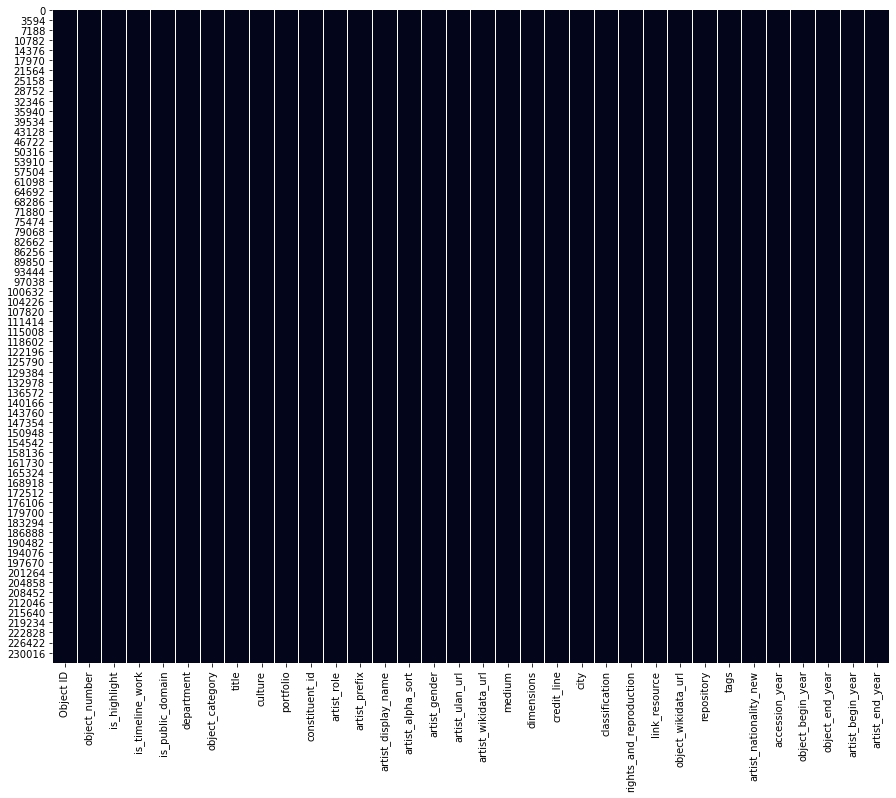

In [53]:
#### Overview of missing data in a heatmap after cleaning
# combined_updated = df.set_index('Object Number')
plt.figure(figsize=(15,12))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [54]:
# After cleaning, lets look at the remaining null-values
df.isnull().mean().sort_values(ascending = False)*100

artist_end_year           0
culture                   0
artist_alpha_sort         0
artist_display_name       0
artist_prefix             0
artist_role               0
constituent_id            0
portfolio                 0
title                     0
artist_begin_year         0
object_category           0
department                0
is_public_domain          0
is_timeline_work          0
is_highlight              0
object_number             0
artist_gender             0
artist_ulan_url           0
artist_wikidata_url       0
medium                    0
dimensions                0
credit_line               0
city                      0
classification            0
rights_and_reproduction   0
link_resource             0
object_wikidata_url       0
repository                0
tags                      0
artist_nationality_new    0
accession_year            0
object_begin_year         0
object_end_year           0
Object ID                 0
dtype: float64

<a id='cleaning'></a>

## Column Cleaning Notes:
Quick process overview for the team to structure our work

<span style="color:green">object_wikidata_url - good for now,potentially scrape if we have time</span>

<span style="color:green">city - cleaned</span> 

<span style="color:green">portfolio  - changed null values to 'No Portfolio'</span>

<span style="color:green">rights_and_reproduction - null values to 'Unknown'</span>

<span style="color:green">culture - null to 'Culture Unknown'</span>

<span style="color:green">artist_prefix - decided to keep(?)</span>

<span style="color:green">object_end_year - handled outlier</span>

<span style="color:green">artist_end_year - handled outlier</span>

<span style="color:green">artist_gender - ran with name recognition, cleaned</span>

<span style="color:green">tags_aat_url - dropped because scraped into tags</span>

<span style="color:green">tags_wikidata_url - drop because scraped into tags</span>

<span style="color:green">tags -listed correctly</span>

<span style="color:green">artist_ulan_url - cleaned</span>

<span style="color:green">death_year - cleaned from artist_end_year</span>

<span style="color:green">artist_nationality - information gathered from artist_bio, cleaned</span>

<span style="color:green">object_begin_year - cleaned</span>

<span style="color:green">artist_wikidata_url - good</span>

<span style="color:green">object_end_year - cleaned</span>

<span style="color:green">birth_year - cleaned from artist_begin_year</span>

<span style="color:green">dimensions - good</span>

<span style="color:green">classification - split into primary & detailed</span>

<span style="color:green">title -null values to 'No title'</span>

<span style="color:green">medium - additional information from title, cleaned</span>

<span style="color:green">accession_year - cleaned</span>

<span style="color:green">object_name - renamed to object_category and replaced null values with 'No Category"</span>

<span style="color:green">credit_line - cleaned</span>

<span style="color:green">constiuent_id - renamed to constituent_id</span>

<span style="color:green">is_highlight - good</span>

<span style="color:green">link_resource - cross referenced with other url, cleaned</span>

<span style="color:green">artist_role - split into primary and detailed description</span>

<span style="color:green">repository - good</span>

<span style="color:green">artist_display_name - good</span>

<span style="color:green">department - good</span>

<span style="color:green">is_public_domain - good</span>

<span style="color:green">artist_display_bio - dropped after extracting all values to other columns</span>

<span style="color:green">is_timeline_work - good</span>

<span style="color:green">object_number - good</span>


## [Top](#top)

## Step 5: Explore and visualize your data
________
#### 5.1 Statistical EDA

In [55]:
# After all cleaning and editing this is the shape of the dataset:
df.shape

(233597, 34)

In [56]:
# For all boolean values we can look at the statistical values (e.g. count, unique, top, freq)
# This does not make sense for the numerical values, since they are only IDs (e.g. Object ID) 

#df.describe(include=['object', 'bool'])

In [57]:
# Check how many unique artists do we actually have?
df["artist_display_name"].nunique()

57529

In [58]:
# Check how many different nationalities do we have?
df["artist_nationality_new"].nunique()

93

In [59]:
# Check what are the value counts of nationalities?
df["artist_nationality_new"].value_counts()[:5]

American    72878
French      44469
Italian     26378
British     24119
Unknown     22833
Name: artist_nationality_new, dtype: int64

In [60]:
# Check how many different departments do we have?
df["department"].nunique()

19

In [61]:
# checking the top 5 Medium entries
df["medium"].value_counts()[:5]

Etching                        16353
Engraving                      10655
Commercial color lithograph     9395
Gelatin silver print            9247
Lithograph                      6165
Name: medium, dtype: int64

In [62]:
# Check number of unique artist per department 
df.groupby('department')[['artist_display_name']].nunique().sort_values(by='artist_display_name',ascending=False).head()

,artist_display_name
department,
Drawings and Prints,37058
European Sculpture and Decorative Arts,4291
Photographs,4184
Modern and Contemporary Art,3650
The American Wing,2557


In [63]:
# Check number of total mediums per artist 
df.groupby('artist_display_name')[['medium']].nunique().sort_values(by='medium',ascending=False).head()

,medium
artist_display_name,
Brewster & Co.,796
James McNeill Whistler,451
Jules-Edmond-Charles Lachaise|Eugène-Pierre Gourdet,319
Sir Francis Seymour Haden,206
Reginald Marsh,168


In [64]:
# Check number of artists by nationality
df.groupby('artist_nationality_new')[['artist_display_name']].nunique().sort_values(by='artist_display_name',ascending=False).reset_index().head()

,artist_nationality_new,artist_display_name
0,American,10912
1,French,10871
2,Italian,7875
3,British,7853
4,Unknown,7240


In [65]:
df["tags"].sample(10)

44074                              [Unknown]
17037                              [Unknown]
54808                              [Unknown]
1953          [Grapes, Hunting, Boars, Dogs]
130220    [Girls, Portraits, Women, Flowers]
10140                              [Unknown]
218085                             [Unknown]
219631                             [Unknown]
160127                         [Abstraction]
145672                                [Fish]
Name: tags, dtype: object

In [66]:
# Let's check for the 5 most used tags
pd.DataFrame(return_top_5_entries(df["tags"]), columns=["Top 5 Tags","Sum"]).style.hide_index()


Top 5 Tags,Sum
Unknown,116588
Men,36096
Women,27182
Portraits,16756
Flowers,5297


In [67]:
# Let's check for the 5 most common artist role descriptions
pd.DataFrame(return_top_5_entries(df["artist_role"]), columns=["Top 5 Artist Roles","Sum"]).style.hide_index()

Top 5 Artist Roles,Sum
Artist,192729
Publisher,64458
Designer,22988
Author,15252
Printer,13709


In [68]:
# Let's check for the 5 most common object classifications
df_class = pd.DataFrame(return_top_5_entries(df["classification"]), columns=["Top 5 Object Classifications","Sum"])
df_class.style.hide_index()

Top 5 Object Classifications,Sum
Prints,100128
Photographs,30184
Drawings,27292
Books,19182
Ephemera,17370


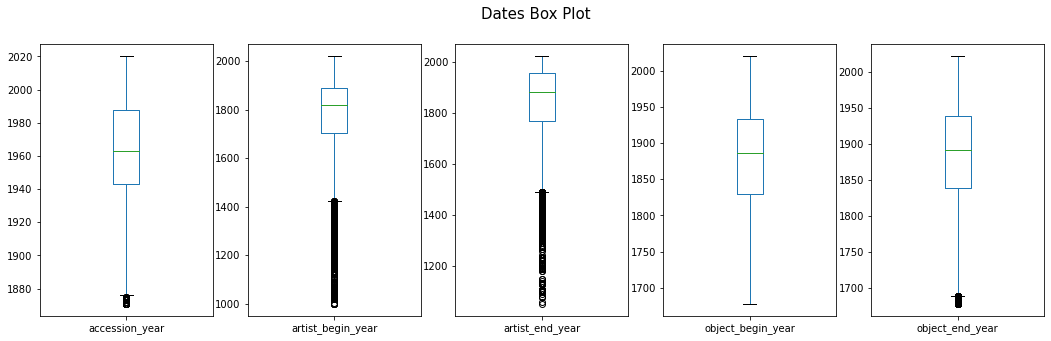


 Statistical data for date columns 

        accession_year  artist_begin_year  artist_end_year  object_begin_year  \
count          231041             203620           173031             191144   
mean          1964.09            1777.89          1843.79            1876.02   
std           30.4511            139.003          136.284            74.4017   
min              1871               1000             1053               1678   
25%              1943               1703             1770               1829   
50%              1963               1819             1882               1886   
75%              1988               1890             1956               1934   
max              2020               2019             2021               2020   

       object_end_year  
count           196379  
mean           1881.86  
std            74.8046  
min               1678  
25%               1839  
50%               1891  
75%               1939  
max               2021  


In [69]:
# box plots for dates
dates = df.replace('Unknown', np.nan)[['accession_year', 'artist_begin_year', 'artist_end_year', 'object_begin_year', 'object_end_year']].astype(float)
plt.rcParams["figure.figsize"] = (18,5)
dates.plot(kind='box', subplots=True)
plt.title('Dates Box Plot', loc='left', fontsize=15, position=(-2.25,1), pad=25)
plt.show()
print('\n', 'Statistical data for date columns \n\n', dates.describe())
# From our outlier handling earlier on, we now see the result of not having any outliers to the upper boundary

#### 5.2 Visual EDA


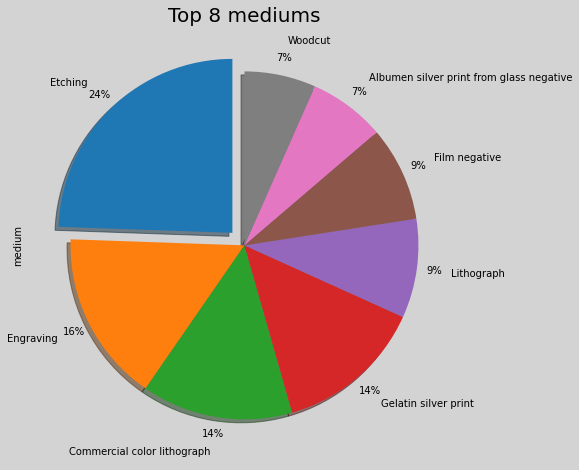

In [80]:
# Let's check the medium of the objects
fig= plt.figure(figsize=(10, 8))
explode = (0.1, 0, 0, 0, 0, 0, 0, 0)  # only "explode" the 1st slice of Etchings to show largest part
df['medium'].value_counts()[:8].plot(kind = 'pie', explode=explode ,autopct='%1.0f%%',pctdistance=1.1, labeldistance=1.2, shadow=True, startangle=90)
fig.set_facecolor('lightgrey')
plt.title("Top 8 mediums", fontsize=20)
plt.show()

So from the mediums the most used is "Etchings"<br>
Usually we would have guessed that it would be something like "Painting" but the entries of the Medium-column lead to the conclusion, that the meaning is a little different than initially thought<br>
So in this case the chart helped to better understand the content of the column<br>

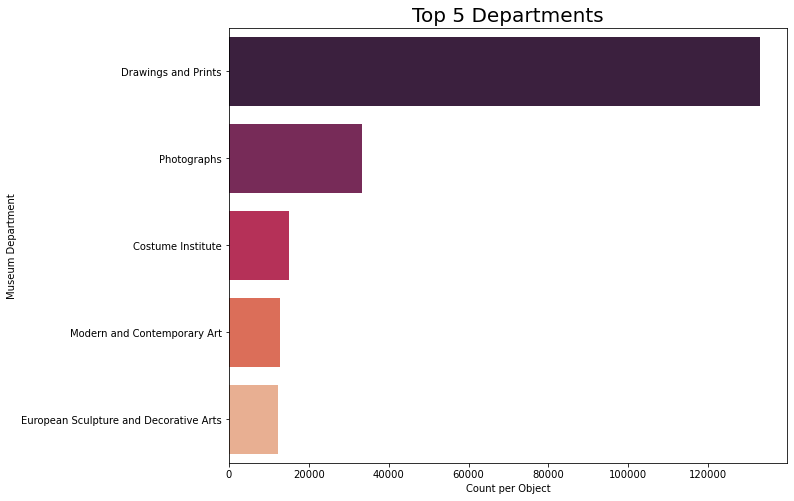

In [72]:
# Let's check in which department of the museum the most artworks are registered
fig= plt.figure(figsize=(10, 8))
sns.countplot(y="department", data=df, palette="rocket",order=df.department.value_counts().iloc[:5].index)
plt.xlabel("Count per Object")
plt.ylabel("Museum Department")
plt.title("Top 5 Departments", fontsize=20)
plt.show()

As we can see (and expected) Drawings and Prints are the main category. More than 50% of all objects are registered in this department<br>

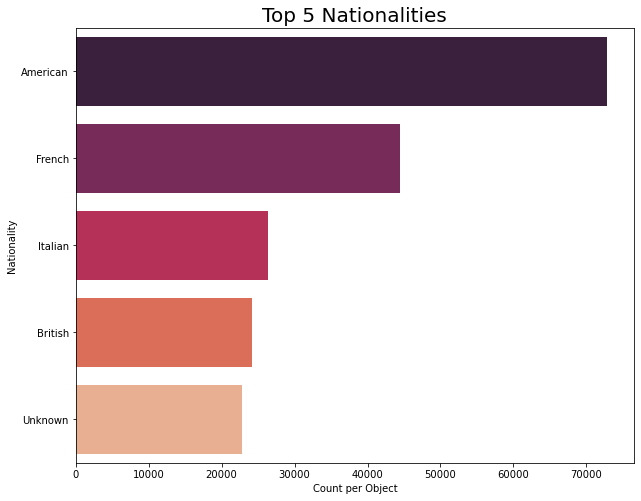

In [81]:
# Let's scan through the artworks and see which nationality of artists contribute the most to the museum's collection
fig= plt.figure(figsize=(10, 8))
sns.countplot(y="artist_nationality_new", data=df, palette="rocket",  order=df.artist_nationality_new.value_counts().iloc[:5].index)
plt.xlabel("Count per Object")
plt.ylabel("Nationality")
plt.title("Top 5 Nationalities", fontsize=20)
plt.show()

Little to no surprise, the American Museum, has the most artworks from American artists.<br>
Followed by French, Italian and British artist

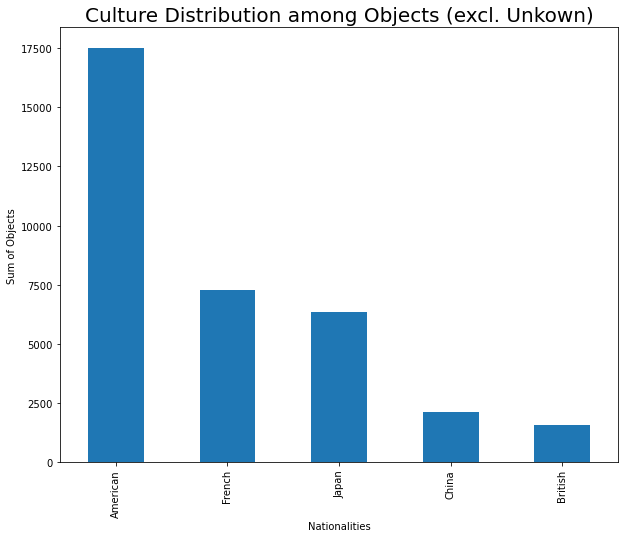

In [74]:
# Let's do a comparable check for the culture-column
fig= plt.figure(figsize=(10, 8))
df['culture'].value_counts()[1:6].plot(kind = 'bar')
plt.xlabel("Nationalities")
plt.ylabel("Sum of Objects")
plt.title("Culture Distribution among Objects (excl. Unkown)", fontsize=20)
plt.show()

We can see that there are certain differences in rankings 3 and 4. <br>
Whilst the artist nationality per object ranks Italian and British, for the culture we see Japan and China. <br>
There are some assumptions why that might be: <br>
 - artworks from an artist with a certain nationality do not necessarily need to belong to the same culture <br>
 - registration bias: from a museums perspective when registrating an object, it might be easier to categorize to "Chinese culture", than e.g. distinguishing between French or Italian (biased perspective) <br>

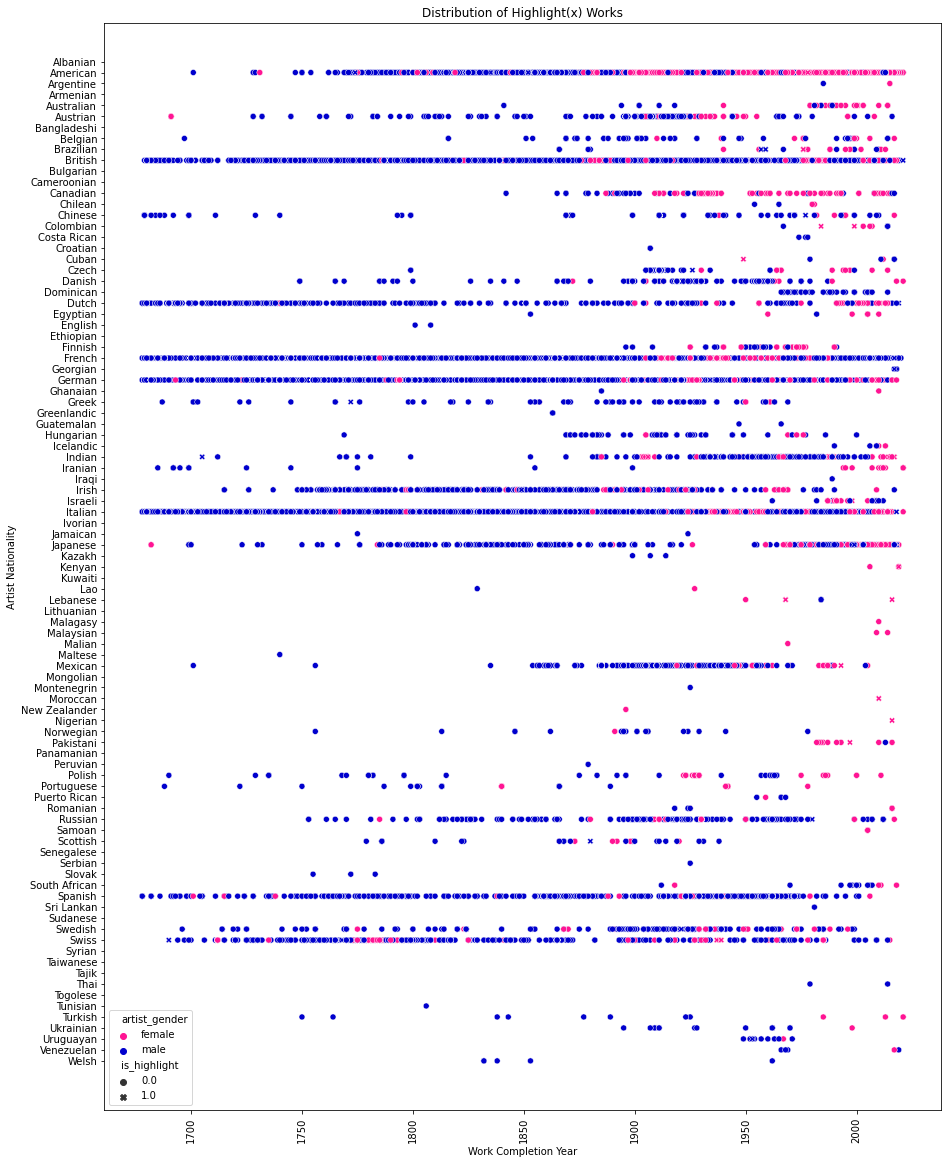

In [82]:
# Plot showing the distribution of artworks in the museum from all nationalities by the year when the work was created.
# the plot also distinguishes whether the work is a highlight of the museam and whether the artist was male or female.

colours = ['deeppink', 'mediumblue']
p = df.replace('Unknown', np.nan).sort_values(by='artist_nationality_new')


plt.rcParams["figure.figsize"] = (15, 20)
pp = sns.scatterplot(data=p, y='artist_nationality_new', x="object_end_year", hue="artist_gender", style="is_highlight", palette=colours)
plt.xticks(rotation=90)
plt.ylabel('Artist Nationality')
plt.xlabel('Work Completion Year')
plt.title('Distribution of Highlight(x) Works')
plt.show()

Distribution of Hightlight(x) notes and observations:<br>
- The amount of female contribution significantly increases in the late 20th century, especially in western countries.
- Tome countries appear to have gaps in years when no artwork was found/contributed (eg.Japan roughly 1940's - 1960's)
- Most highlight works come from the 19th century or later.
- Some nationalities have only female or majority female contributions (Pakistani, New Zealander, Nigerian, Moroccan, Malian, Malasian, etc.)

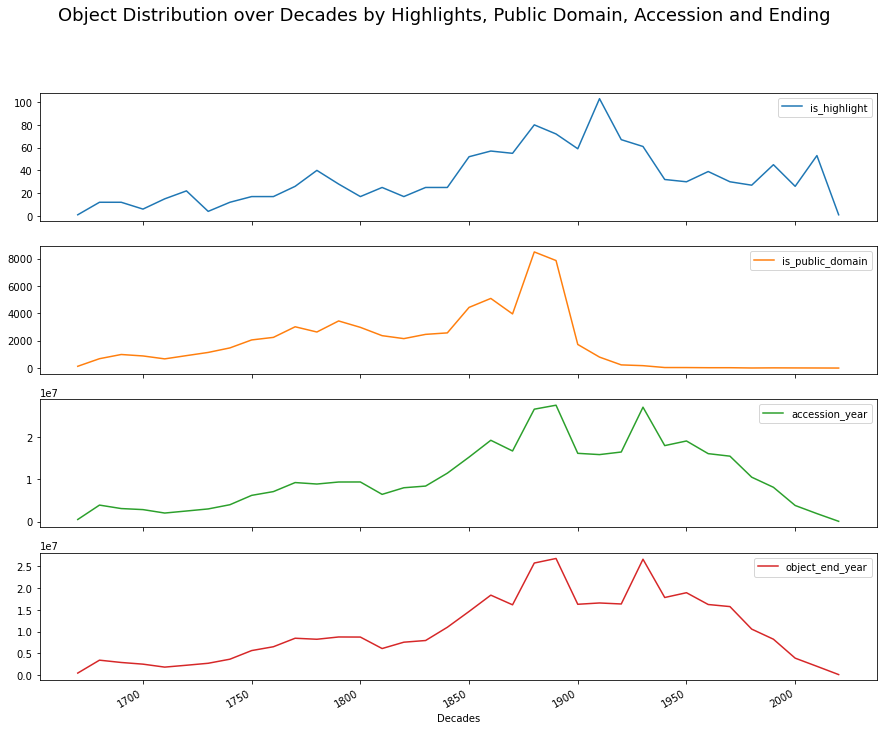

In [103]:
# Let's check the activity over time of the museum and the museum's collection distribution across centuries
df_decade = df[["is_highlight","is_public_domain","accession_year","object_end_year"]].replace("Unknown", np.nan).astype("float")

object_end_decades = df_decade.groupby((df_decade.object_end_year//10)*10).sum()
object_end_decades.plot(subplots=True)
plt.rcParams["figure.figsize"] = (15,12)
plt.suptitle('Object Distribution over Decades by Highlights, Public Domain, Accession and Ending', fontsize=18)
plt.xlabel('Decades')
plt.show()

Distribution of museum's collection over decades - notes and observations:<br>
- Overall number of highlights is low (max. 100) in comparison to total artworks (230k)
- In every decade (from 1650 to present) are highlighted artworks represented, but the main peak is around the beginning of the 20th century
- There is a steep increase in the amount of works considered public domain in the latter half of the 19th century, followed by a radical decline at the beginning of the 20th century
- On the contrary, is highlight works and the number of objects continue to increase, suggesting some sort of event or ideology change that caused organizations or entities to claim ownership over the objects
- The distribution of the accession year shows a steady growth of the museum's collection until the beginning of the 20th century
- The amount of added artworks to the museum's collection drops from 1950 onwards
- The object end year data shows almost the same behaviour as the accession year

In [112]:
# Preparing a new dataset to look at correlation values
df_corr = convert_cat_2_num(df.drop(["tags","artist_role","classification","repository"],axis=1))

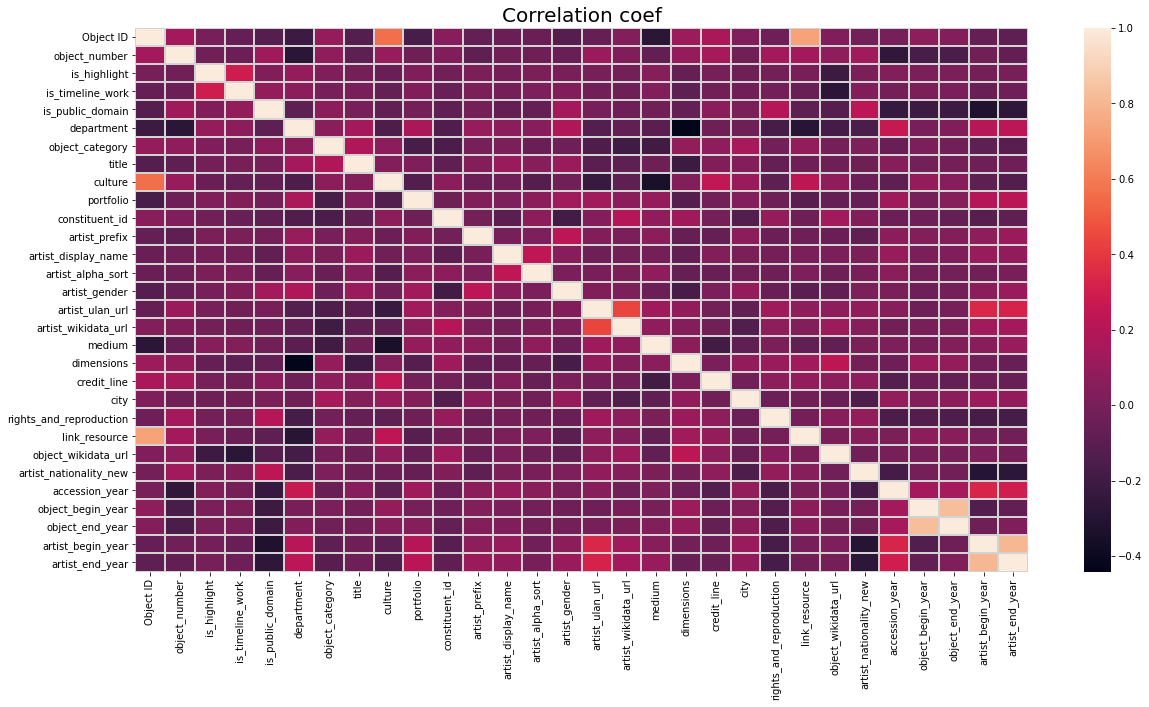

In [118]:
# Let's check for correlations between columns
plt.figure(figsize=(20,10))
corr = df_corr[df_corr.columns].corr()
plt.title("Correlation coef", fontsize=20)
sns.heatmap(corr,annot=False, linecolor="lightgrey", linewidth=1);

The correlation matrix above reveals no new valuable information about correlation

## Step 6: Ending

In [78]:
# During working with the dataset we observed some beautifull piece of art 
# This is one of the treasures we found :)
df[df['title'].str.contains('treasure')][["title","object_category","object_wikidata_url"]]

,title,object_category,object_wikidata_url
147145,"Vignette, headpeace of the second canto, depic...",Print,Unknown
227094,"Book 4, Fable 13: the treasure (Le trésor)",Print,Unknown


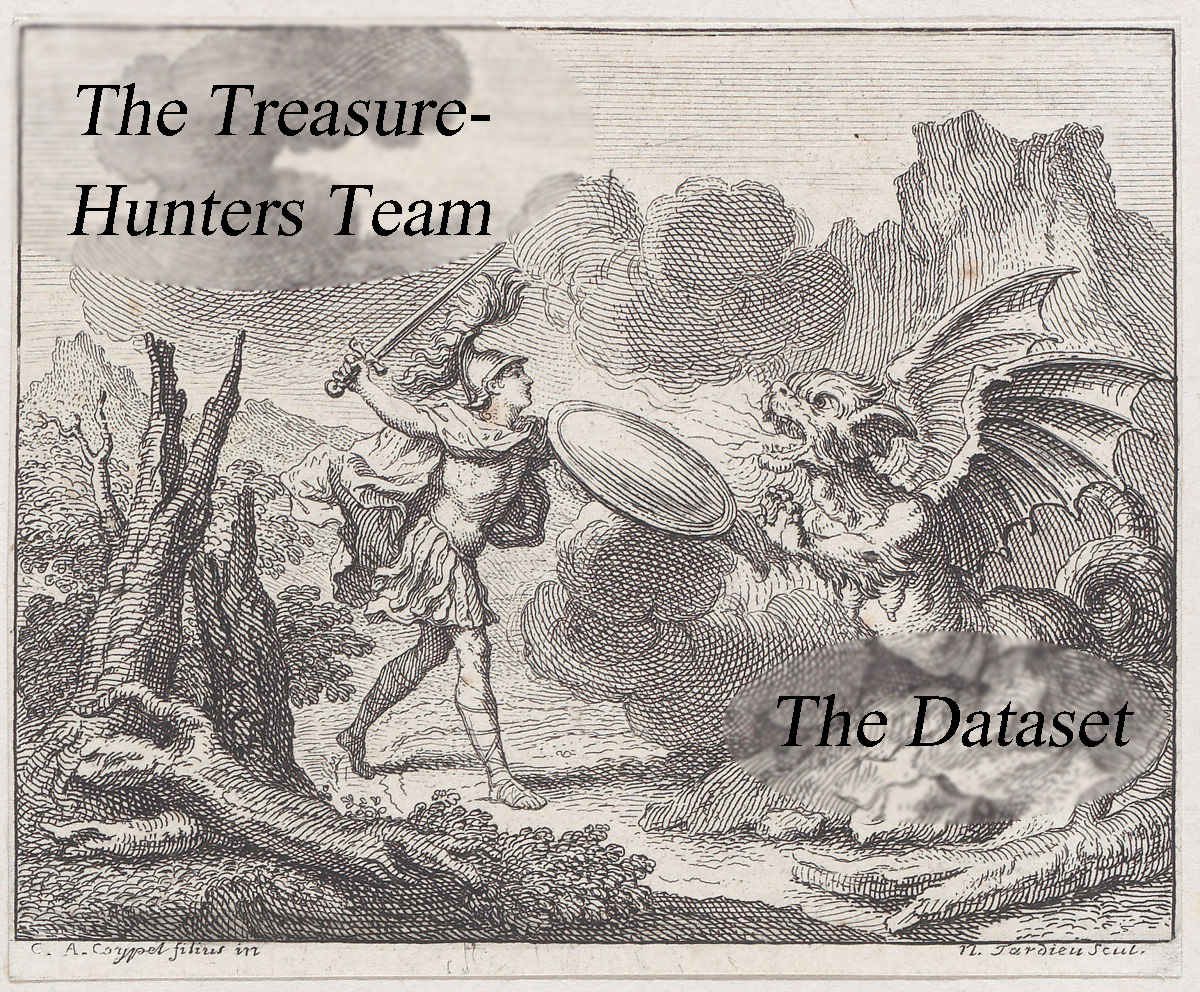

None


In [79]:
x = Image(filename="Team_image.jpg") 
print(display(x))

<span  style="color:orange; font-size: 200%;">+++ Thanks for reading +++</span>


### BACKUP

Color Palettes:<br>
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [ ]:
df[df["is_highlight"] == 1][["title","object_wikidata_url"]].sample(10)